Written by $\text{Bastien Zimmermann}$ research engineer at Craft.AI

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Xai-Libraries-a-tour-of-the-possibilities" data-toc-modified-id="Xai-Libraries-a-tour-of-the-possibilities-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Xai Libraries a tour of the possibilities</a></span><ul class="toc-item"><li><span><a href="#Load-Dataset" data-toc-modified-id="Load-Dataset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load Dataset</a></span></li></ul></li><li><span><a href="#Train-a-lgbm" data-toc-modified-id="Train-a-lgbm-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Train a lgbm</a></span></li><li><span><a href="#Plot-PCA-TSNE" data-toc-modified-id="Plot-PCA-TSNE-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot PCA TSNE</a></span></li><li><span><a href="#Alibi" data-toc-modified-id="Alibi-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Alibi</a></span><ul class="toc-item"><li><span><a href="#Anchors" data-toc-modified-id="Anchors-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Anchors</a></span><ul class="toc-item"><li><span><a href="#same-with-xgboost" data-toc-modified-id="same-with-xgboost-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>same with xgboost</a></span></li></ul></li><li><span><a href="#Counterfactual" data-toc-modified-id="Counterfactual-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Counterfactual</a></span></li></ul></li><li><span><a href="#Shap" data-toc-modified-id="Shap-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Shap</a></span></li><li><span><a href="#Fat-Forensics" data-toc-modified-id="Fat-Forensics-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Fat Forensics</a></span></li><li><span><a href="#References" data-toc-modified-id="References-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>References</a></span></li></ul></div>

$\textbf{Definition Interpretability:}$ 

$\hspace{30pt}1. \hspace{4pt} \text{Interpretability is the degree to which a human can understand the cause of a decision.}$
$\hspace{320pt}\textit{Tim Miller}$

$\hspace{30pt}2. \hspace{4pt} \text{degree to which a human can consistently predict the model’s result.}$
$\hspace{320pt}\textit{B. Kim et al.}$



# Xai Libraries a tour of the possibilities

## Load Dataset

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, Normalizer, MinMaxScaler, StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier,LogisticRegression

import shap

from alibi.explainers import AnchorTabular, CounterfactualProto, Counterfactual

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import tensorflow as tf

import fatf.utils.data.datasets as fatf_datasets
import fatf.utils.models as fatf_models
import fatf.transparency.models.feature_influence as fatf_fi
import fatf.vis.feature_influence as fatf_vis_fi

2022-05-02 18:05:18.919914: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bastienzim/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-05-02 18:05:18.919934: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
22-May-02 18:05:21 fatf.utils.array.tools INFO     Using numpy's numpy.lib.recfunctions.structured_to_unstructured as fatf.utils.array.tools.structured_to_unstructured and fatf.utils.array.tools.structured_to_unstructured_row.


In [76]:
warnings.filterwarnings('ignore')

In [77]:
#Load data
df = pd.read_csv('./penguins_lter.csv')

# Handling missing values

#setting strategy to 'most frequent' to impute by the mean
imputer = SimpleImputer(strategy='most_frequent')# strategy can also be mean or median 
df.iloc[:,:] = imputer.fit_transform(df)
#encode categorical
df = df[df.Sex.isin(["MALE","FEMALE"])]

lb = LabelEncoder()
df["Sex"] = lb.fit_transform(df["Sex"])
lb2 = LabelEncoder()
df["Island"] = lb2.fit_transform(df["Island"])

#Drop unused columns
df.drop(columns= ["Individual ID","studyName","Sample Number","Region",
                  "Delta 15 N (o/oo)","Delta 13 C (o/oo)","Comments","Stage",
                 "Clutch Completion", "Date Egg"], inplace = True)

In [78]:
df.sample(6)

Species  Island  Culmen Length (mm)  \
146  Adelie Penguin (Pygoscelis adeliae)       1                39.2   
257    Gentoo penguin (Pygoscelis papua)       0                44.4   
225    Gentoo penguin (Pygoscelis papua)       0                46.5   
104  Adelie Penguin (Pygoscelis adeliae)       0                37.9   
119  Adelie Penguin (Pygoscelis adeliae)       2                41.1   
139  Adelie Penguin (Pygoscelis adeliae)       1                39.7   

     Culmen Depth (mm)  Flipper Length (mm)  Body Mass (g)  Sex  
146               18.6                190.0         4250.0    1  
257               17.3                219.0         5250.0    1  
225               13.5                210.0         4550.0    0  
104               18.6                193.0         2925.0    0  
119               18.6                189.0         3325.0    1  
139               17.9                193.0         4250.0    1

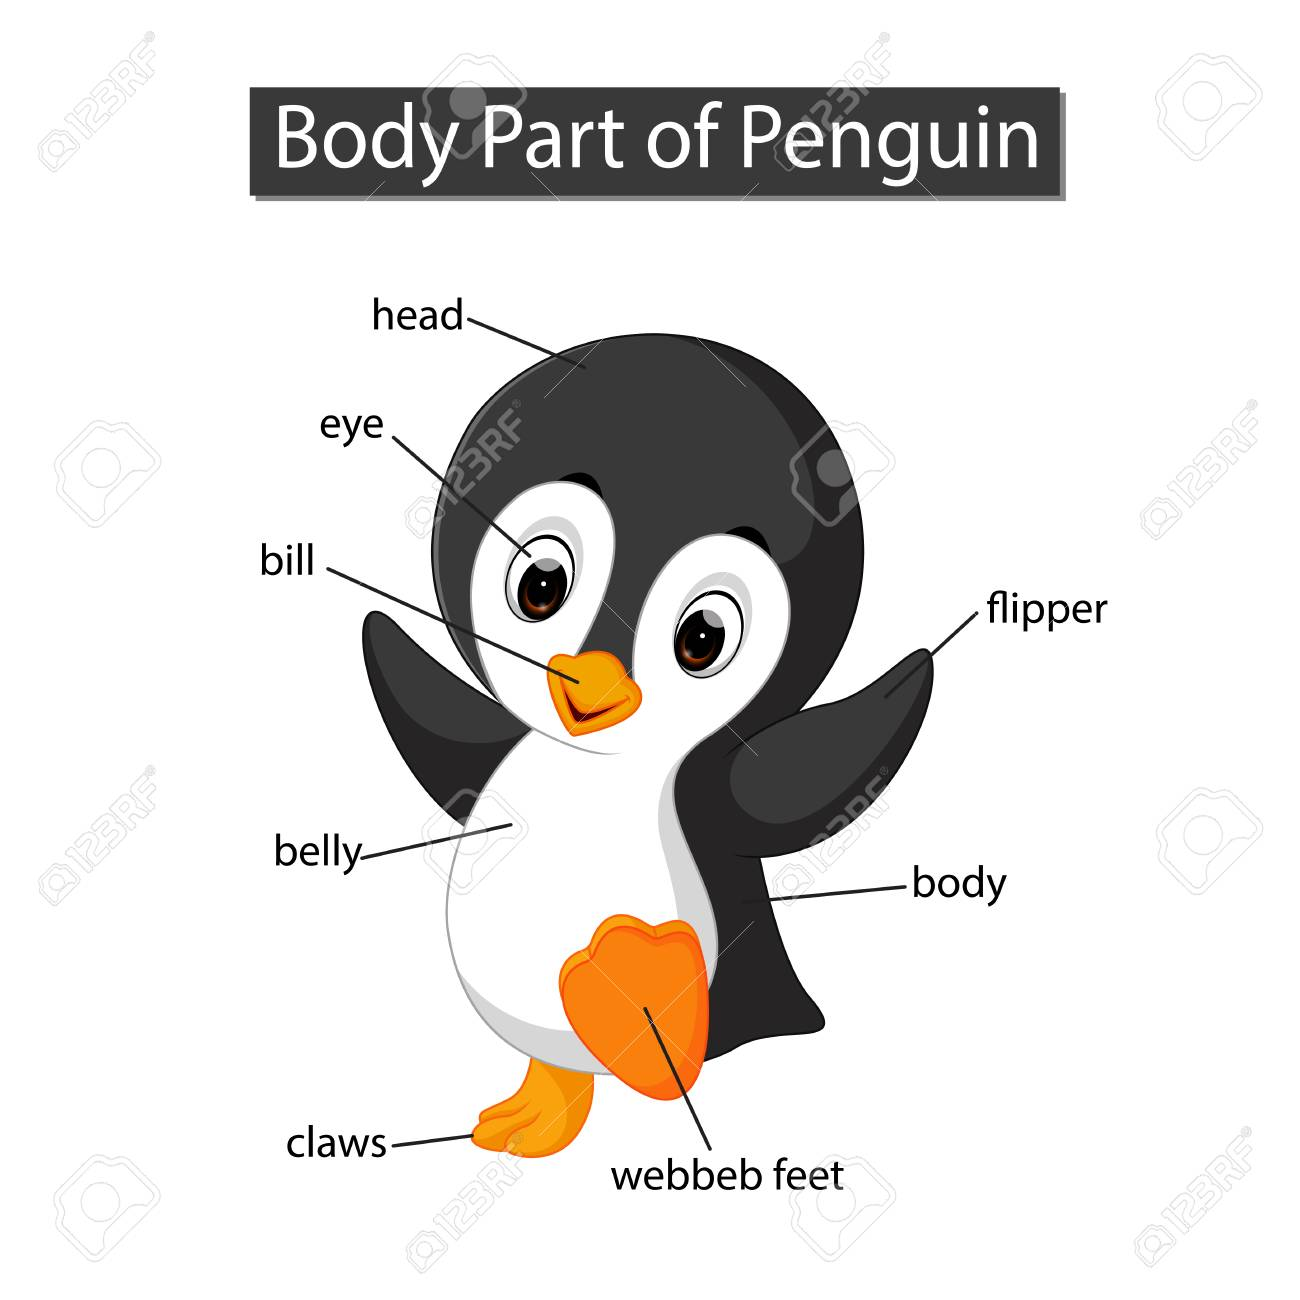

# Train a lgbm

In [79]:
df_learn = df.copy()

X = df_learn.drop(columns = 'Species')
y = df_learn.loc[:,["Species"]]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, 
    random_state=3254, 
    shuffle=True)

In [80]:
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)
lgbm.score(X_test, y_test)

0.9912280701754386

In [81]:
xgb = XGBClassifier()

xgb.fit(X_train, y_train)
xgb.score(X_test, y_test)

[17:52:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9736842105263158

In [82]:
ridge = RidgeClassifier()
ridge.fit(X_train, y_train.values.ravel())
ridge.score(X_test, y_test.values.ravel())

0.9912280701754386

In [83]:
lr = LogisticRegression(solver='liblinear')
lr.fit(X_train, y_train.values.ravel())
lr.score(X_test, y_test.values.ravel())

0.9649122807017544

# Plot PCA TSNE

In [84]:
#compute TSNE
tsne_results = TSNE(n_components=2, perplexity=11).fit_transform(df.drop(columns = 'Species'))
#Compute PCA
pca = PCA()
pca_results = pca.fit_transform(df.drop(columns = 'Species'))
#prepare plot
df_plot = df.copy()
df_plot['tsne-one'], df_plot['tsne-two'] = tsne_results[:,0], tsne_results[:,1]
df_plot['pca-one'],  df_plot['pca-two']  = pca_results[:,0],  pca_results[:,1] 

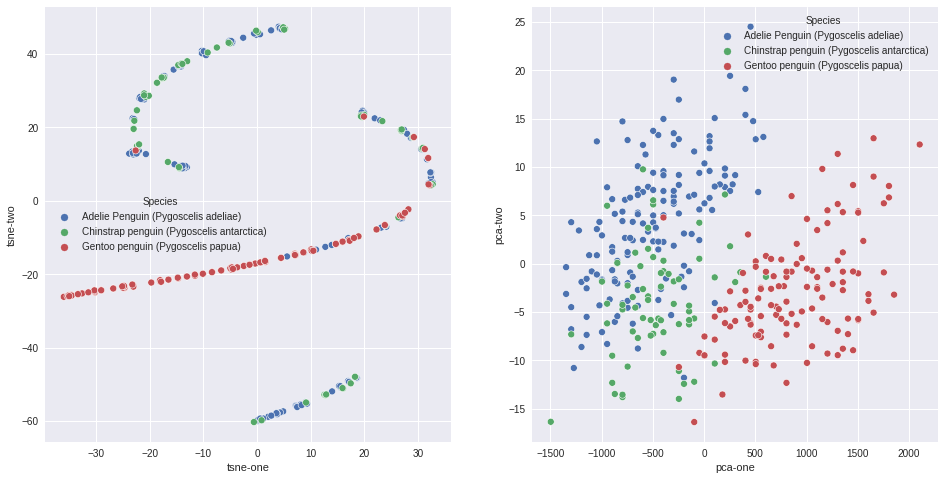

In [85]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize = [16,8])
sns.scatterplot(x="tsne-one", y="tsne-two", hue="Species",
                data=df_plot, legend="full", ax = ax[0])
sns.scatterplot( x="pca-one", y="pca-two", hue="Species",
                data=df_plot, legend="full", ax = ax[1])


plt.savefig("pcatsne.png")
plt.show()

Text(0.5, 1.0, 'PCA explained variance ratio')

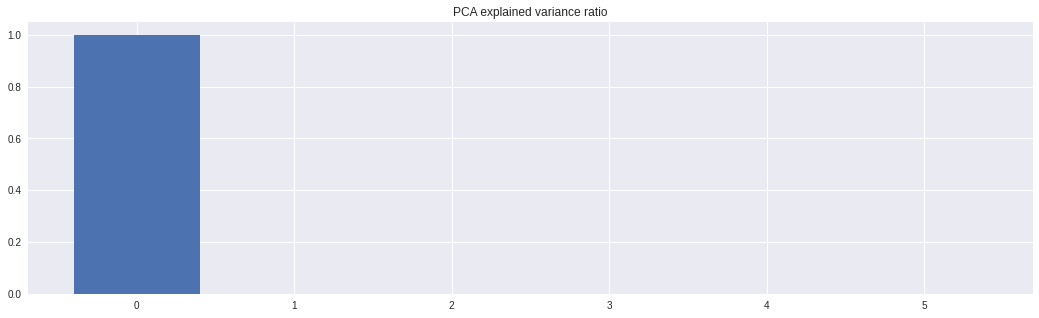

In [86]:
#PCA Explained Variance
plt.figure(figsize =[18,5])
plt.bar(np.arange(pca_results.shape[1]), pca.explained_variance_ratio_)
plt.title("PCA explained variance ratio")

In [87]:
penguin_dict = {x.split(" ")[0]:i for i,x in enumerate(lgbm.classes_)}

# Alibi

## Anchors

In [88]:
predict_fn = lambda x: lgbm.predict_proba(x)
explainer = AnchorTabular(predict_fn, X_train.columns)
explainer.fit(X_train.values, disc_perc=(25, 50, 75))

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'seed': None, 'disc_perc': (25, 50, 75)},
  'version': '0.6.4'}
)

In [89]:
idx_bob = [np.random.randint(1,50)]
idx_bob=[43]
print(X_test.values[idx_bob])
print(' Prediction: ', [lgbm._classes[x] for x in explainer.predictor(X_test.values[idx_bob])])

explanation = explainer.explain(X_test.values[idx_bob], threshold=0.95)
print(f' Anchor: {" AND ".join(explanation.anchor) :s}')
print(f' Precision: {explanation.precision :.2f}')
print(f' Coverage:  {explanation.coverage :.2f}')

[[0.00e+00 4.52e+01 1.58e+01 2.15e+02 5.30e+03 1.00e+00]]
 Prediction:  ['Gentoo penguin (Pygoscelis papua)']
 Anchor: Island <= 0.00 AND Flipper Length (mm) > 210.00
 Precision: 1.00
 Coverage:  0.25


### same with xgboost

In [90]:
predict_fn = lambda x: xgb.predict_proba(x)
explainer = AnchorTabular(predict_fn, X_train.columns)
explainer.fit(X_train.values, disc_perc=(25, 50, 75))

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'seed': None, 'disc_perc': (25, 50, 75)},
  'version': '0.6.4'}
)

In [91]:
idx_bob = [np.random.randint(1,50)]
idx_bob=[43]
print(X_test.values[idx_bob])
print(' Prediction: ', [xgb.classes_[x] for x in explainer.predictor(X_test.values[idx_bob])])

explanation = explainer.explain(X_test.values[idx_bob], threshold=0.95)
print(f' Anchor: {" AND ".join(explanation.anchor) :s}')
print(f' Precision: {explanation.precision :.2f}')
print(f' Coverage:  {explanation.coverage :.2f}')

[[0.00e+00 4.52e+01 1.58e+01 2.15e+02 5.30e+03 1.00e+00]]
 Prediction:  ['Gentoo penguin (Pygoscelis papua)']
 Anchor: Flipper Length (mm) > 210.00 AND Body Mass (g) > 4700.00
 Precision: 0.98
 Coverage:  0.22


In [92]:
df.loc[idx_bob]

Species  Island  Culmen Length (mm)  \
43  Adelie Penguin (Pygoscelis adeliae)       1                44.1   

    Culmen Depth (mm)  Flipper Length (mm)  Body Mass (g)  Sex  
43               19.7                196.0         4400.0    1

## Counterfactual

This method is counterfactuals guided by prototypes. 

$\text{Interpretable Counterfactual Explanations Guided by Prototypes. Van Looveren, Arnaud, and Janis Klaise. 2020.}$

https://arxiv.org/abs/1907.02584

In [93]:
lr = LogisticRegression(solver='liblinear')
lr.fit(X_train, y_train.values.ravel())
lr.score(X_test, y_test.values.ravel())

0.9649122807017544

In [94]:
predict_fn = lambda x: lgbm.predict_proba(x)
predict_fn_xgb = lambda x: xgb.predict_proba(x)
predict_fn_ridge = lambda x: ridge.predict(x)
predict_fn_lr = lambda x: lr.predict_proba(x)

In [95]:
tf.compat.v1.disable_eager_execution()

In [96]:
cfProto = CounterfactualProto(predict_fn_lr, X.iloc[[0]].shape)

In [97]:
cfProto.fit(X_train.values, disc_perc=(25, 50, 75))

CounterfactualProto(meta={
  'name': 'CounterfactualProto',
  'type': ['blackbox', 'tensorflow', 'keras'],
  'explanations': ['local'],
  'params': {
              'kappa': 0.0,
              'beta': 0.1,
              'feature_range': (-10000000000.0, 10000000000.0),
              'gamma': 0.0,
              'theta': 0.0,
              'cat_vars': None,
              'ohe': False,
              'use_kdtree': False,
              'learning_rate_init': 0.01,
              'max_iterations': 1000,
              'c_init': 10.0,
              'c_steps': 10,
              'eps': (0.001, 0.001),
              'clip': (-1000.0, 1000.0),
              'update_num_grad': 1,
              'write_dir': None,
              'shape': (1, 6),
              'is_model': False,
              'is_ae': False,
              'is_enc': False,
              'enc_or_kdtree': False,
              'is_cat': False,
              'trustscore_kwargs': None,
              'd_type': 'abdm',
              'w': None,
  

In [98]:
%%time
idx_bob=[43]
explanation = cfProto.explain(X_test.values[idx_bob])

CPU times: user 27.3 s, sys: 1.21 s, total: 28.5 s
Wall time: 24.9 s


In [99]:
df_cf = pd.DataFrame(columns=X_test.columns)
df_cf.loc["Real"] = X_test.values[idx_bob][0]
df_cf.loc["Counterfactual"] = explanation.data['cf']['X'][0]
print(lgbm.predict([df_cf.loc["Real"].values]), lgbm.predict([df_cf.loc["Counterfactual"].values]))
print(lr.predict([df_cf.loc["Real"].values]), lr.predict([df_cf.loc["Counterfactual"].values]))
df_cf.round(2)

['Gentoo penguin (Pygoscelis papua)'] ['Gentoo penguin (Pygoscelis papua)']
['Gentoo penguin (Pygoscelis papua)'] ['Adelie Penguin (Pygoscelis adeliae)']


Island  Culmen Length (mm)  Culmen Depth (mm)  \
Real               0.0               45.20              15.80   
Counterfactual     0.0               44.46              17.43   

                Flipper Length (mm)  Body Mass (g)  Sex  
Real                          215.0         5300.0  1.0  
Counterfactual                215.0         5300.0  1.0

Another counterfactual method, this one with lgbm. This is the first counterfactual method that appears in the litterature. 

$\text{Counterfactual Explanations Without Opening the Black Box: Automated Decisions and the GDPR. Wachter, Sandra, Brent Mittelstadt, and Chris Russell. 2017.}$

https://ojs.aaai.org/index.php/AAAI/article/view/11491

In [100]:
cf = Counterfactual(predict_fn_lr, X.iloc[[0]].shape, distance_fn='l1',
                   target_proba=0.75, target_class='other')

In [101]:
%%time
idx_bob = [np.random.randint(1,len(X_test))]
print(idx_bob)
idx_bob=[16]
explanation = cf.explain(X_test.values[idx_bob])

[49]
CPU times: user 4.19 s, sys: 195 ms, total: 4.38 s
Wall time: 3.92 s


In [102]:
df_cf = pd.DataFrame(columns=X_test.columns)
df_cf.loc["Real"] = X_test.values[idx_bob][0]
df_cf.loc["Counterfactual"] = explanation.data['cf']['X'][0]
print(lgbm.predict([df_cf.loc["Real"].values]), lgbm.predict([df_cf.loc["Counterfactual"].values]))
df_cf.round(2)

['Gentoo penguin (Pygoscelis papua)'] ['Adelie Penguin (Pygoscelis adeliae)']


Island  Culmen Length (mm)  Culmen Depth (mm)  \
Real               0.0                42.0              13.50   
Counterfactual     0.0                42.0              16.59   

                Flipper Length (mm)  Body Mass (g)  Sex  
Real                          210.0         4150.0  0.0  
Counterfactual                210.0         4150.0  0.0

# Shap

In [103]:
explainer = shap.TreeExplainer(model=xgb, data = X_train, feature_perturbation="interventional",
                               model_output="raw")
shap_values = explainer.shap_values(X_test)

In [104]:
shap.initjs()
class_selected = penguin_dict['Gentoo']
print(f"Prediction for class {xgb.classes_[class_selected]}")
idx_bob = 43
shap.force_plot(explainer.expected_value[class_selected], 
            shap_values[class_selected][idx_bob,:], X_test.iloc[idx_bob,:])

Prediction for class Gentoo penguin (Pygoscelis papua)


In [105]:
class_selected = penguin_dict['Chinstrap']
print(f"Prediction for class {xgb.classes_[class_selected]}")
idx_bob = 43
shap.force_plot(explainer.expected_value[class_selected], 
            shap_values[class_selected][idx_bob,:], X_test.iloc[idx_bob,:])

Prediction for class Chinstrap penguin (Pygoscelis antarctica)


In [106]:
class_selected = penguin_dict['Adelie']
print(f"Prediction for class {xgb.classes_[class_selected]}")
idx_bob = 43
shap.force_plot(explainer.expected_value[class_selected], 
            shap_values[class_selected][idx_bob,:], X_test.iloc[idx_bob,:])

Prediction for class Adelie Penguin (Pygoscelis adeliae)


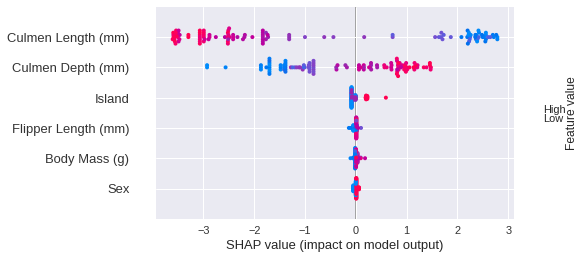

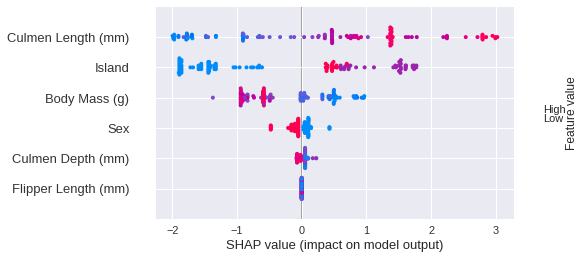

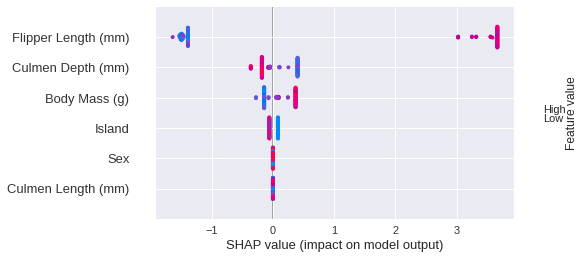

In [107]:
shap.summary_plot(np.array(shap_values)[0,:,:], X_test.iloc[:1000,:])#, plot_type="layered_violin")
shap.summary_plot(np.array(shap_values)[1,:,:], X_test.iloc[:1000,:])#, plot_type="layered_violin")
shap.summary_plot(np.array(shap_values)[2,:,:], X_test.iloc[:1000,:])#, plot_type="layered_violin")

# Fat Forensics

In [108]:
penguins_list = [x.split(" ")[0] for x in lgbm.classes_]

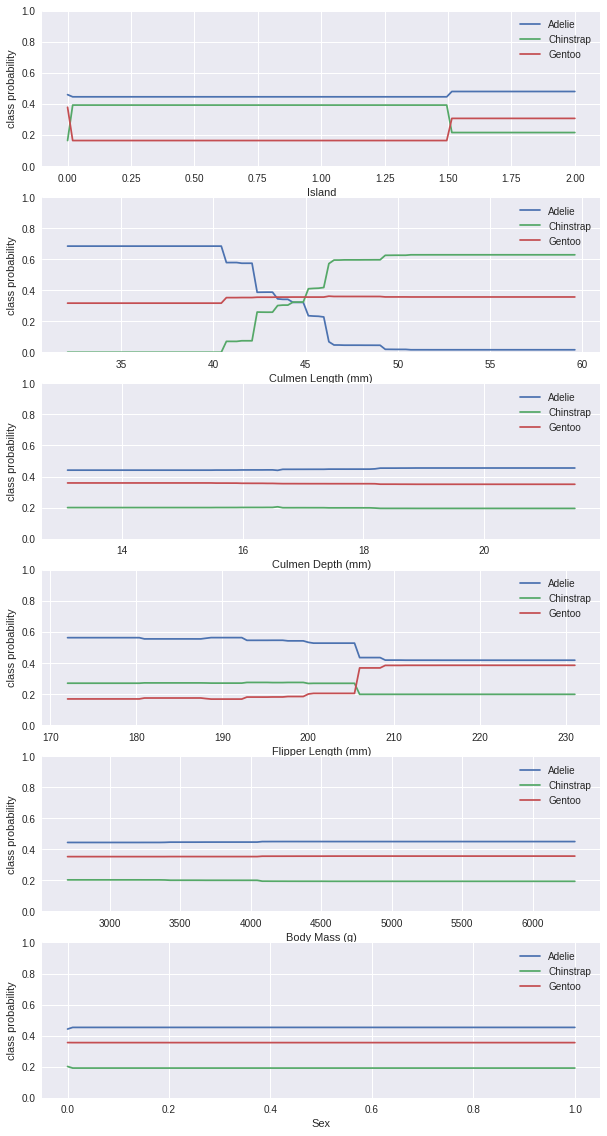

In [109]:
fig, ax = plt.subplots(nrows=len(X.columns), ncols=1, figsize = [10,20])
for i_col, col in enumerate(X.columns):
    for i in range(3):
        pd_array, pd_linspace = fatf_fi.partial_dependence(
            X.values, lgbm, i_col)
        ax[i_col].plot(pd_linspace, pd_array[:,i], label =f"{penguins_list[i]}")

        ax[i_col].set_ylim(0,1)
        ax[i_col].legend()
    ax[i_col].set_xlabel(col)
    ax[i_col].set_ylabel(f"class probability")
plt.show()

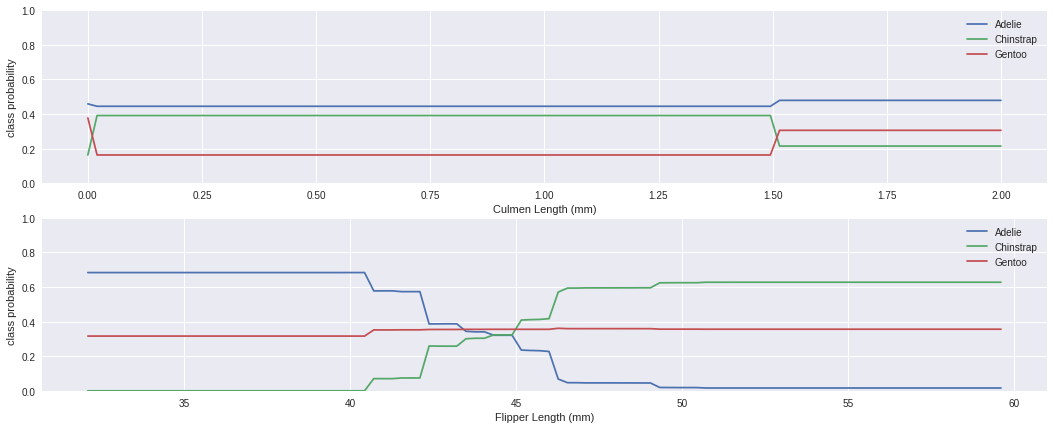

In [110]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = [18,7])
for i_col, col in enumerate(['Culmen Length (mm)', 'Flipper Length (mm)']):
    for i in range(3):
        pd_array, pd_linspace = fatf_fi.partial_dependence(
            X.values, lgbm, i_col)
        ax[i_col].plot(pd_linspace, pd_array[:,i], label =f"{penguins_list[i]}")

        ax[i_col].set_ylim(0,1)
        ax[i_col].legend()
    
    ax[i_col].set_xlabel(col)
    ax[i_col].set_ylabel(f"class probability")
plt.show()

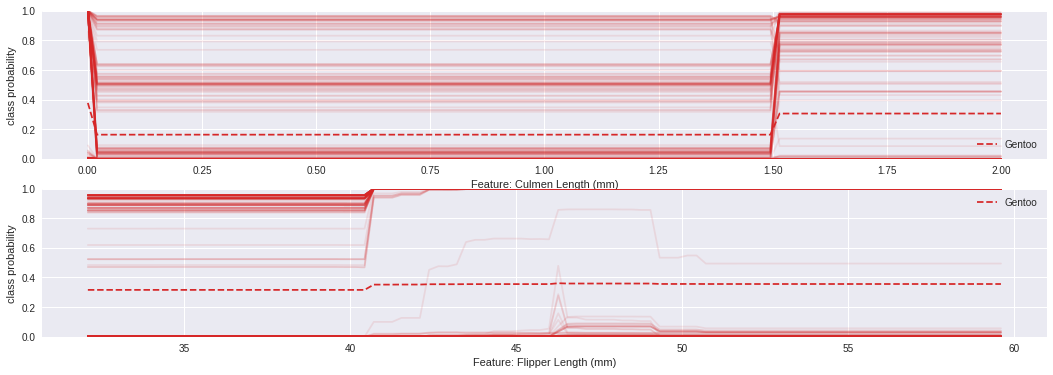

In [111]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = [18,6])
for i_col, col in enumerate(['Culmen Length (mm)', 'Flipper Length (mm)']):
    for i in [2]:#range(3):


        # Create an ICE explanation
        ice_array, ice_linspace = fatf_fi.individual_conditional_expectation(
            X.values, lgbm, i_col)
        for i_ice in range(ice_array.shape[0]):
            ax[i_col].plot(ice_linspace, ice_array[i_ice,:,i], alpha=0.1, 
                           color=sns.palettes.color_palette("tab10")[3])
        ax[i_col].plot(ice_linspace, ice_array.mean(axis=0)[:,i], label =f"{penguins_list[i]}", 
                           color=sns.palettes.color_palette("tab10")[3],
                       linestyle='dashed')

    ax[i_col].set_ylim(0,1)
    ax[i_col].legend()
    ax[i_col].set_xlabel(f"Feature: {col}")
    ax[i_col].set_ylabel(f"class probability")
        
    
plt.show()

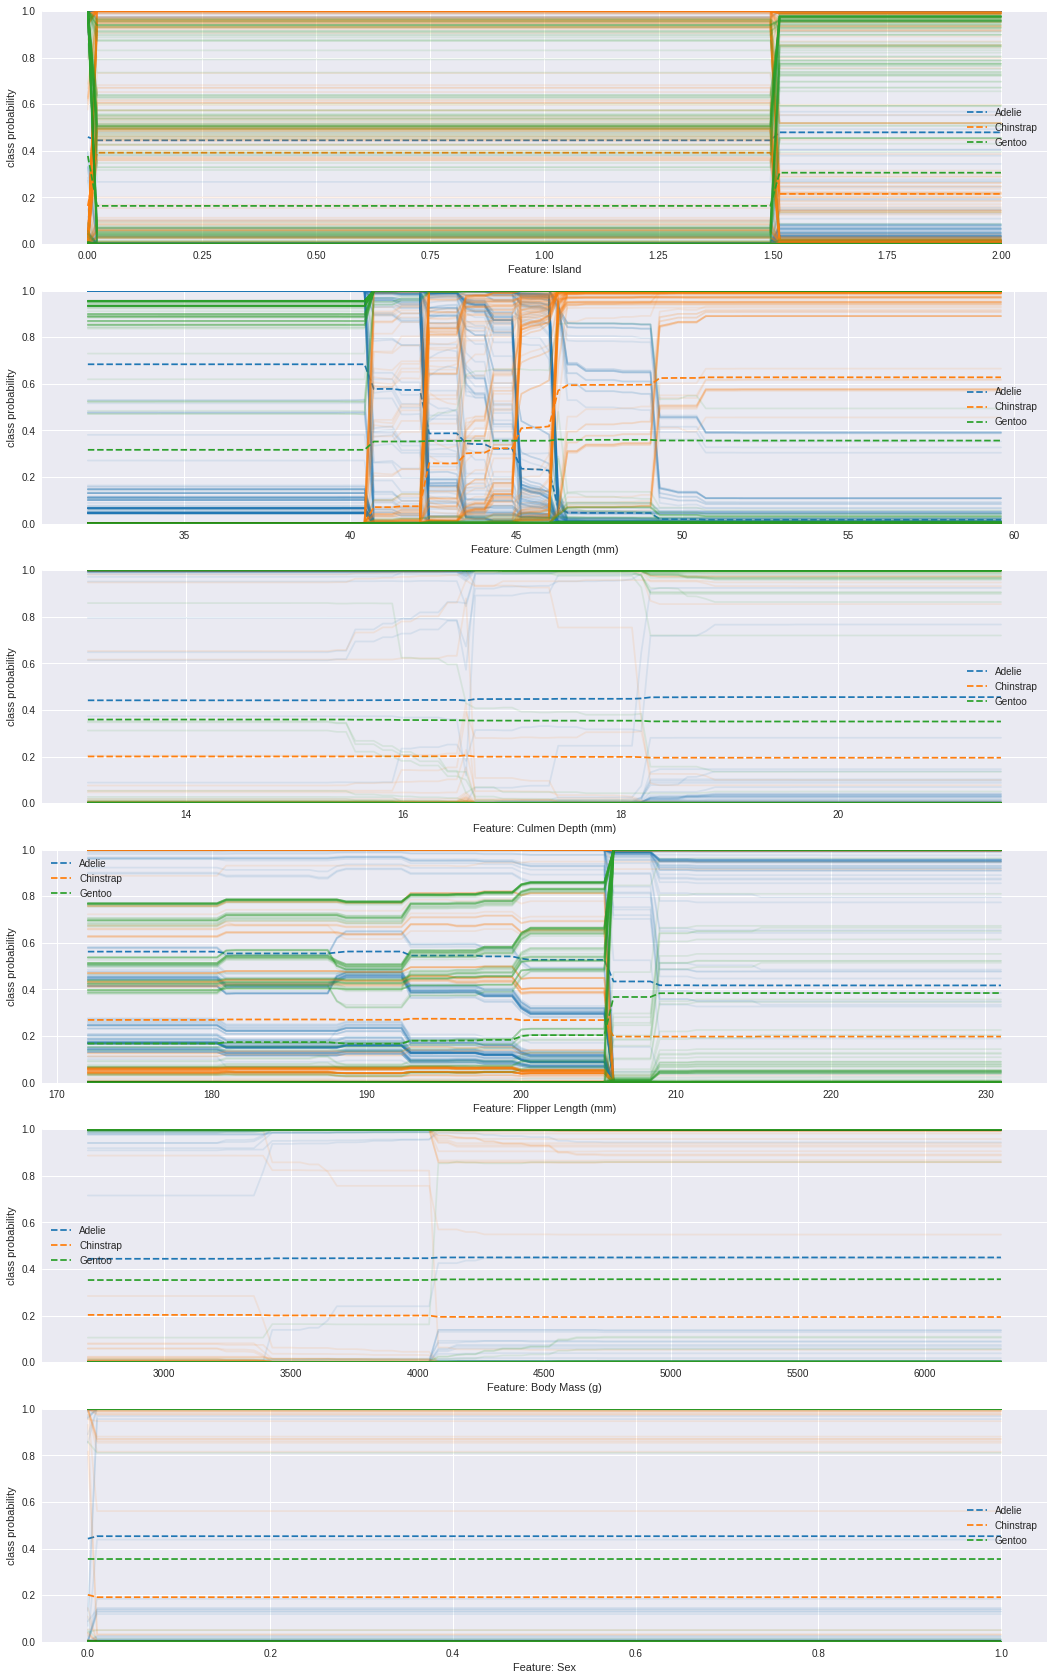

In [112]:
fig, ax = plt.subplots(nrows=len(X.columns), ncols=1, figsize = [18,30])
for i_col, col in enumerate(X.columns):
    for i in range(3):


        # Create an ICE explanation
        ice_array, ice_linspace = fatf_fi.individual_conditional_expectation(
            X.values, lgbm, i_col)
        for i_ice in range(ice_array.shape[0]):
            ax[i_col].plot(ice_linspace, ice_array[i_ice,:,i], alpha=0.1, 
                           color=sns.palettes.color_palette("tab10")[i])
        ax[i_col].plot(ice_linspace, ice_array.mean(axis=0)[:,i], label =f"{penguins_list[i]}", 
                           color=sns.palettes.color_palette("tab10")[i],
                       linestyle='dashed')

    ax[i_col].set_ylim(0,1)
    ax[i_col].legend()
    ax[i_col].set_xlabel(f"Feature: {col}")
    ax[i_col].set_ylabel(f"class probability")
        
    
plt.show()

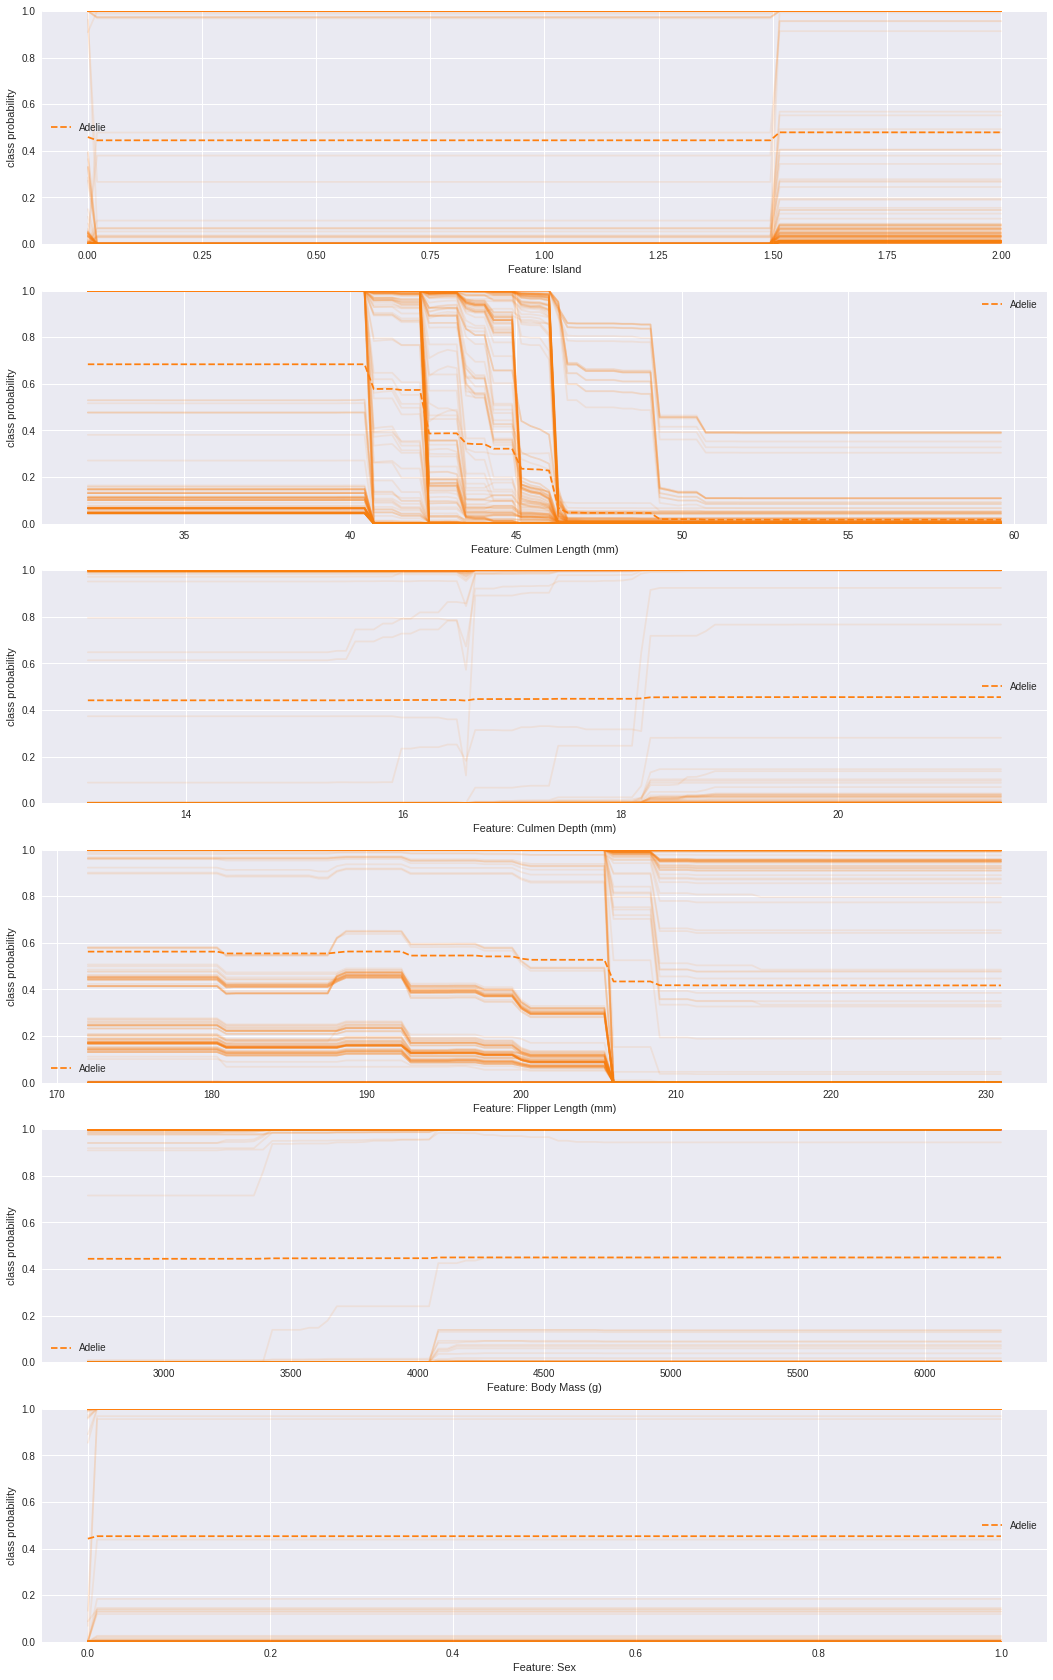

In [113]:
fig, ax = plt.subplots(nrows=len(X.columns), ncols=1, figsize = [18,30])
for i_col, col in enumerate(X.columns):
    i=0


    # Create an ICE explanation
    ice_array, ice_linspace = fatf_fi.individual_conditional_expectation(
        X.values, lgbm, i_col)
    for i_ice in range(ice_array.shape[0]):
        ax[i_col].plot(ice_linspace, ice_array[i_ice,:,i], alpha=0.1, 
                       color=sns.palettes.color_palette("tab10")[i+1])
    ax[i_col].plot(ice_linspace, ice_array.mean(axis=0)[:,i], label =f"{penguins_list[i]}", 
                       color=sns.palettes.color_palette("tab10")[i+1],
                   linestyle='dashed')

    ax[i_col].set_ylim(0,1)
    ax[i_col].legend()
    ax[i_col].set_xlabel(f"Feature: {col}")
    ax[i_col].set_ylabel(f"class probability")
        
    
plt.show()

# References

- [1] Interpretable Machine Learning, Christoph Molnar [link](https://christophm.github.io/interpretable-ml-book/)
- [2] Assessing the trustworthiness of saliency maps for localizing abnormalities in medical imaging, Arun et al, 2021. [link](https://pubs.rsna.org/doi/abs/10.1148/ryai.2021200267)
- [3] “Anchors: High Precision Model-Agnostic Explanations” Ribeiro, Marco Tulio, Sameer Singh, and Carlos Guestrin. 2018. [link](https://ojs.aaai.org/index.php/AAAI/article/view/11491)
- [4] Counterfactual Explanations Without Opening the Black Box: Automated Decisions and the GDPR. Wachter, Sandra, Brent Mittelstadt, and Chris Russell. 2017. [link](https://ojs.aaai.org/index.php/AAAI/article/view/11491)
- [5] A Unified Approach to Interpreting Model Predictions S. Lundberg and S. Lee 2017. [link](https://proceedings.neurips.cc/paper/2017/hash/8a20a8621978632d76c43dfd28b67767-Abstract.html)
- [6] AI Explainability 360: An Extensible Toolkit for Understanding Data and Machine Learning Models, Arya et al, 2020. [link](https://www.jmlr.org/papers/v21/19-1035.html)
- [7] Captum: A unified and generic model interpretability library for PyTorch, Kokhlikyan et al., 2020. [link](https://arxiv.org/abs/2009.07896)
- [8] Interpretable Counterfactual Explanations Guided by Prototypes. Van Looveren, Arnaud, and Janis Klaise. 2020.  [link](https://arxiv.org/abs/1907.02584)
- [9] Examples are not enough, learn to criticize! Criticism for interoperability.  K, Been et al. 2016. [link](https://papers.nips.cc/paper/2016/hash/5680522b8e2bb01943234bce7bf84534-Abstract.html)
- [10] Explanation in Artificial Intelligence: Insights from the Social Sciences. Miller, Tim. 2018. [link](http://arxiv.org/abs/1706.07269)